# Reconstruction with real data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

#config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import ab_initio, ab_initio_mcmc
from src.residual import get_volume_residual
import jax

import mrcfile

plt.rcParams["figure.figsize"]=6,6

### Read the data

In [3]:
#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/CaltechWeaver/"
#star_file = "job550_particles_subsamp5_10000_30_40_2.star"
#star_file = "job550_particles_roy40k.star"
#star_file = "job550_particles.star"


#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/Frost/eIF2B/job042/"
#star_file = "AUG11_99Kparticles_updatedGCTF.star"

#data_dir = "/project/lederman/rrl28/share/CryoEMDataSmall/RelionSample/relion30_tutorial_precalculated_results/"
#star_file = "Extract/job020/particles.star"

#data_dir = "/gpfs/gibbs/pi/lederman/dge5/RELION_TUTORIAL_SET/PrecalculatedResults/"
#star_file = "/Extract/job018/particles.star"

#data_dir = "/gpfs/gibbs/pi/lederman/3DFSC_data/tilted/Particle-Stack/"
#star_file = "T40_HA_130K-Equalized_run-data.star"

#data_dir = "/gpfs/gibbs/pi/lederman/EMPIAR-10028/"
#star_file = "shiny_2sets.star"

data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
star_file = "particles_crossvalidation_train_1.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)
ctf_params0 = params0["ctf_params"]
pixel_size0 = params0["pixel_size"]
angles0 = params0["angles"]
shifts0 = params0["shifts"]


/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles:  105519
load_data: data loaded, time:  73.65003633499146


In [4]:
print(imgs0.shape)
print(pixel_size0.shape)
print(angles0.shape)
print(shifts0.shape)
print(ctf_params0.shape)

#plt.imshow(np.abs(jnp.fft.fftshift(imgs_f0[101]))); plt.colorbar()

(105519, 320, 320)
(105519,)
(105519, 3)
(105519, 2)
(105519, 9)


In [5]:
pixel_size0

array([1.31, 1.31, 1.31, ..., 1.31, 1.31, 1.31])

In [6]:
shifts0

array([[-10.09712, -20.57712],
       [-10.09712,  -4.85712],
       [-11.40712,  13.48288],
       ...,
       [-38.91712,  -4.85712],
       [ 13.48288,  -4.85712],
       [ -2.23712, -20.57712]])

In [7]:
jnp.min(shifts0)

DeviceArray(-90.00712, dtype=float64)

In [8]:
jnp.max(jnp.abs(shifts0))/pixel_size0[0]

DeviceArray(68.70772519, dtype=float64)

### Only keep N points at random (to avoid out of memory error)

In [9]:
# Actually this only permutes the first 5000, not great
N = 5000 # imgs0.shape[0]
idxrand = np.random.permutation(100000)[:N]
#idxrand = np.random.permutation(N)[:N]

imgs0 = imgs0[idxrand]
pixel_size = pixel_size0[idxrand]
angles = angles0[idxrand]
shifts = shifts0[idxrand]
ctf_params = ctf_params0[idxrand]

In [10]:
file2 = open('../data/cryodrgn/idxrand','wb')
pickle.dump(idxrand, file2)
file2.close()

### Some angle filtering

In [11]:
#idx = jnp.abs(angles0[:,2]) < jnp.pi/4
#imgs_f = imgs_f0[idx]
#pixel_size = pixel_size0[idx]
#angles = angles0[idx]
#shifts = shifts0[idx]
#ctf_params = ctf_params0[idx]

#idx2 = jnp.abs(angles[:,1]) < jnp.pi/3
#imgs_f = imgs_f[idx2]
#pixel_size = pixel_size[idx2]
#angles = angles[idx2]
#shifts = shifts[idx2]
#ctf_params = ctf_params[idx2]

#plot_angles(angles)

### Take the FFT of the images

In [12]:
t0 = time.time()
imgs_f = np.array([np.fft.fft2(np.fft.ifftshift(img)) for img in imgs0])
print(time.time()-t0)

13.633727312088013


### Create the grids

In [13]:
# Assume the pixel size is the same for all images
nx = imgs_f.shape[-1]
px = pixel_size[0]
N = imgs_f.shape[0]

x_grid = create_grid(nx, px)
y_grid = x_grid
z_grid = x_grid
print(x_grid)

[2.38549618e-03 3.20000000e+02]


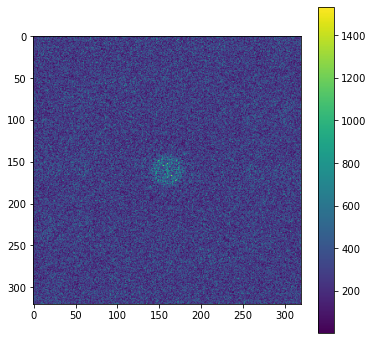

In [14]:
plt.imshow(np.abs(jnp.fft.fftshift(imgs_f[103]))); plt.colorbar()

### Crop images to 32 x 32 

In [15]:
nx = 64
imgs_f, x_grid = crop_fourier_images(imgs_f, x_grid, nx)

y_grid = x_grid
z_grid = x_grid
print(x_grid)

[2.38549618e-03 6.40000000e+01]


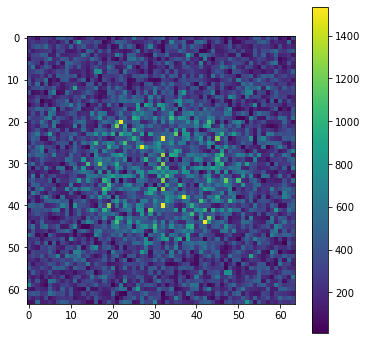

In [16]:
plt.imshow(np.abs(jnp.fft.fftshift(imgs_f[103].reshape([nx,nx])))); plt.colorbar()

### Before further processing, vectorize the images, create mask etc

In [17]:
imgs_f = imgs_f.reshape(N, -1)
print(imgs_f.shape)

(5000, 4096)


In [18]:
#plt.imshow(np.abs(jnp.fft.fftshift(imgs_f2[103].reshape(nx,nx)))); plt.colorbar()

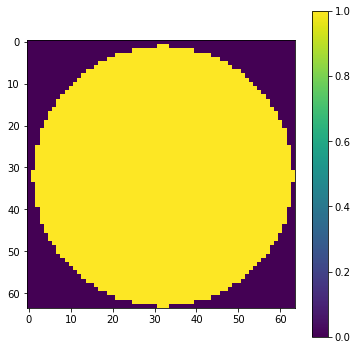

In [19]:
centre = (0,0,0)
#radius = 0.048 # for nx=32
#radius = 0.035
#radius = 0.093 # nx-64
radius = 0.074
#radius = 0.07 # for nx=64
#radius = 0.198 # for nx=128
#radius = 0.28 # for nx=256

mask = create_3d_mask(x_grid, centre, radius)

mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

### Estimate the noise

First, decide on the dimensions of the empty corners to use for noise estimation:

In [20]:
imgs0.shape

(5000, 320, 320)

In [21]:
N_noise = 48
#plt.imshow(jnp.mean(imgs0[:,:N_noise,:N_noise], axis=0))

Only use a small subset of the data for noise estimation so the kernel doesn't crash (possibly due to running out of memory)

Text(0.5, 1.0, 'Estimated noise')

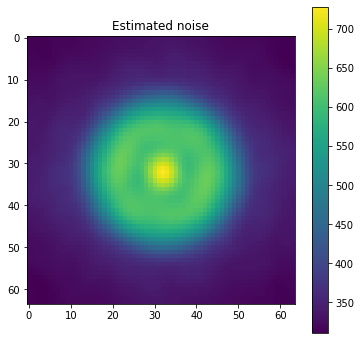

In [22]:
sigma_noise_estimated = estimate_noise_imgs(imgs0[:5000], nx_empty = N_noise, nx_final = nx).reshape([nx,nx])
plt.imshow(jnp.fft.fftshift(sigma_noise_estimated)); plt.colorbar()
plt.title('Estimated noise')

#### Average radially

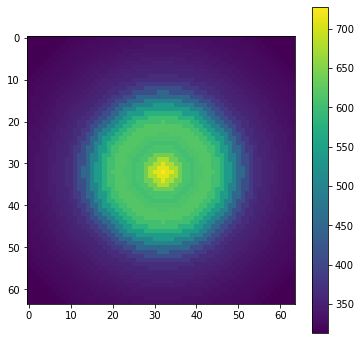

In [23]:
sigma_noise_avg = average_radially(sigma_noise_estimated, x_grid)

plt.imshow(jnp.fft.fftshift(sigma_noise_avg)); plt.colorbar()

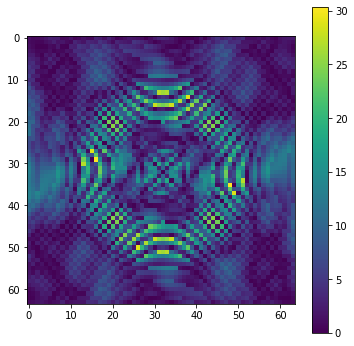

In [24]:
plt.imshow(jnp.fft.fftshift(jnp.abs(sigma_noise_avg-sigma_noise_estimated))); plt.colorbar()

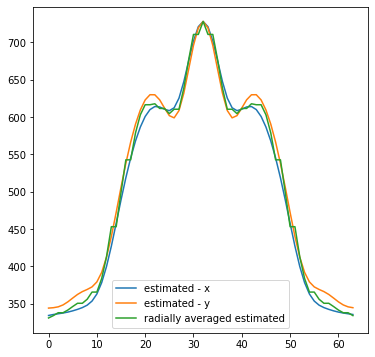

In [25]:
plt.plot(jnp.fft.fftshift(sigma_noise_estimated[:,0]))
plt.plot(jnp.fft.fftshift(sigma_noise_estimated[0,:]))
plt.plot(jnp.fft.fftshift(sigma_noise_avg[:,0]))
plt.legend(['estimated - x', 'estimated - y', 'radially averaged estimated'])

In [26]:
sigma_noise = sigma_noise_avg.reshape(-1)

### Delete the real images
Since we only work with the Fourier ones from now on.

In [27]:
del(imgs0)
#del(imgs)

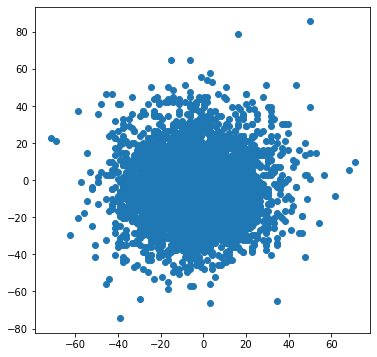

In [28]:
plt.scatter(shifts[:,0], shifts[:,1])

### Ab initio

Actual pixel size for 32 x 32 images is:

In [29]:
pixel_size[0]*(320/nx)

6.550000000000001

In [30]:
80/6.55 

12.213740458015268

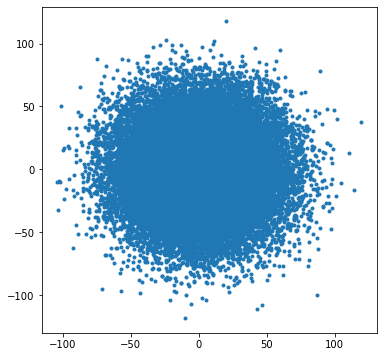

In [31]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))
pixel_size_nx = pixel_size[0] * 320/nx
B = pixel_size_nx*nx/15

sh = generate_gaussian_shifts(key, N, B)
plt.plot(sh[:,0], sh[:,1], '.')

In [32]:
#old_stdout = sys.stdout
#sys.stdout = open('../data/relion/output.txt', 'w')

In [33]:
#sys.stdout = sys.__stdout__

In [34]:
#v_rec_int = v_rec
#angles_rec_int = angles_rec

In [444]:
imgs_f.shape

(40000, 4096)

In [69]:
# Split in batches, note that imgs_batch stays on the CPU (i.e. np not jnp)
N_batch = 1
imgs_batch = np.array(np.array_split(imgs_f, N_batch))
angles_batch = jnp.array(np.array_split(angles, N_batch))
shifts_batch = jnp.array(np.array_split(shifts, N_batch))
ctf_params_batch = jnp.array(np.array_split(ctf_params, N_batch))

Fourier radius: 0.07633587786259541
Starting radius: 0.01
Frequency marching step size: 0.004131800590574611
Number of frequency marching steps: 17
------------------------------------

Initialitsing volume
  sgd epoch 0: mean gradient = 7.843130892306089e-08


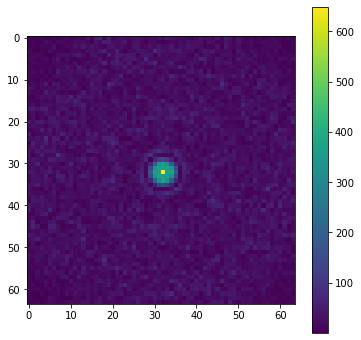

Iter  0
Sampling orientations
batch  0
  MC sample 100 , loss = 35.25950333301948
  MC sample 200 , loss = 35.2592327610522
  MC sample 300 , loss = 35.25925321865598
  MC sample 400 , loss = 35.25946299996171
  Time orientations sampling = 7.0420122146606445
  mean(a_angles) = 0.9911081762353667
Sampling the volume
  Iter 100 , a =  0.9999790420618763
  MC sample 100 , loss = 30.998092764933084
  Time volume sampling = 11.600426197052002
  mean(a_vol) = 0.9999937206824925
2022-03-25 17:30:51.949177
  nx = 10


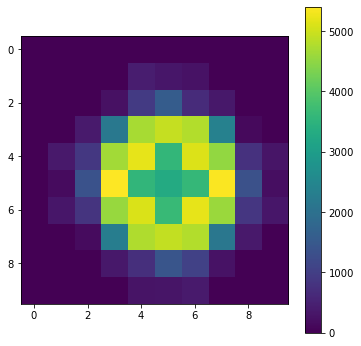

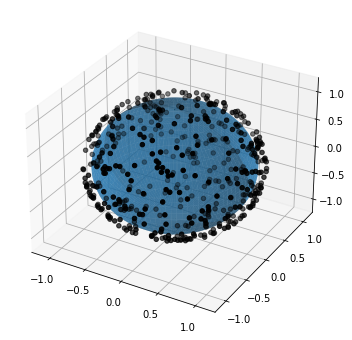

Iter  1
Sampling orientations
batch  0
  MC sample 100 , loss = 56.2544294754679
  MC sample 200 , loss = 56.243241514226945
  MC sample 300 , loss = 56.24873879814356
  MC sample 400 , loss = 56.25446194003585
  Time orientations sampling = 8.3656325340271
  mean(a_angles) = 0.8657705257742903
Sampling the volume
  Iter 100 , a =  0.9999303330645566
  MC sample 100 , loss = 56.25914210710717
  Time volume sampling = 11.406622409820557
  mean(a_vol) = 0.9999898211586217
Iter  2
Sampling orientations
batch  0
  MC sample 100 , loss = 55.18979456377218
  MC sample 200 , loss = 55.18960836365014
  MC sample 300 , loss = 55.17986691231947
  MC sample 400 , loss = 55.19096100412726
  Time orientations sampling = 4.527419090270996
  mean(a_angles) = 0.7691694849944875
Sampling the volume
  Iter 100 , a =  0.999925836386156
  MC sample 100 , loss = 56.15335323123882
  Time volume sampling = 2.134685754776001
  mean(a_vol) = 0.9999897597208515


In [70]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

# The number of iterations desn't matter, 
# since it stops when the volume is nx x nx x nx.
N_samples = 40000
N_iter = 3 #1000000

radius0 = 0.01
#radius0 = 0.03
#radius0 = 0.04 #0.05
alpha = 1e-9  # <--- this is the working one
#alpha = 1e-6

# The number of cg or sgd iterations also doesn't matter,
# since it stops when it reaches the desired accuracy.
N_cg_iter = 100000
eps_cg = 3e-5

N_sgd_iter = 100000
batch_size = 300
learning_rate = 1e6
#learning_rate = 1
#eps_gd = 1e-8 
eps_gd = 2e-7
P = None

use_sgd = True

if use_sgd:
    N_vol_iter = N_sgd_iter
    eps_vol = eps_gd
else:
    N_vol_iter = N_cg_iter
    eps_vol = eps_cg

N_samples_vol = 101   
N_samples_angles = 500# 1000 
N_samples_shifts = 500 # 1000

# HMC params
#dt = 5
dt_list = jnp.array([0.1, 0.5, 1, 5, 10])
L = 5

pixel_size_nx = pixel_size[0] * 320/nx
B = pixel_size_nx*nx/15
B_list = jnp.array([B, B/2, B/4, B/8])

vol0 = None
angles0 = None
shifts0 = shifts_batch
#sigma_noise = jnp.ones(sigma_noise.shape)
    
out_dir = '../data/cryodrgn/'
imgs_f = imgs_f.reshape([N, nx*nx])

opt_vol_first = True

#v_rec, angles_rec = ab_initio(project, imgs_f, sigma_noise, shifts, ctf_params, x_grid, use_sgd, N_iter, N_vol_iter, learning_rate, batch_size, P, N_samples, radius0, None, alpha, eps_vol, 'tri', True, True, True, out_dir)

v_rec, angles_rec, shifts_rec = ab_initio_mcmc(key, 
                                   project, 
                                   rotate_and_interpolate,
                                   apply_shifts_and_ctf,
                                   imgs_batch, 
                                   sigma_noise, 
                                   ctf_params_batch, 
                                   x_grid, 
                                   use_sgd, 
                                   vol0,
                                   angles0,
                                   shifts0,
                                   N_iter, 
                                   learning_rate, 
                                   batch_size, 
                                   P, 
                                   N_samples_vol,
                                   N_samples_angles, 
                                   N_samples_shifts,
                                   dt_list, 
                                   L, 
                                   radius0, 
                                   None, 
                                   alpha, 
                                   eps_vol,
                                   B_list,
                                   'tri', 
                                   opt_vol_first, True, True, out_dir)

In [437]:
aa = 10
jnp.ndim(aa)

0

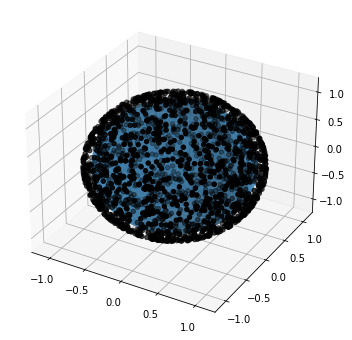

In [36]:
plot_angles(angles_rec[:2000])

In [ ]:
plt.plot(shifts_rec[:,0], shifts_rec[:,1], '.')

In [ ]:
print(jnp.max(shifts_rec))
print(jnp.min(shifts_rec))
print(jnp.mean(shifts_rec))
      

In [ ]:
plt.plot(shifts_rec[:,1])

In [ ]:
pixel_size_nx

In [ ]:
from src.utils import wrap_arround_distance_2d_array

In [ ]:
print(pixel_size_nx*64)
print(pixel_size[0]*320)

In [ ]:
serr = wrap_arround_distance_2d_array(shifts, shifts_rec, pixel_size_nx * 32)
plt.plot(serr)
print(jnp.mean(serr))
print(jnp.max(serr))

In [ ]:
jnp.mean(shifts)

In [ ]:
x_grid0 = jnp.array([x_grid[0], 256])
print(x_grid)
print(x_grid0)
x_freq = jnp.fft.fftfreq(int(x_grid[1]), 1/(x_grid[0]*x_grid[1]))
x_freq0 = jnp.fft.fftfreq(int(x_grid0[1]), 1/(x_grid0[0]*x_grid0[1]))

In [ ]:
x_freq

In [ ]:
x_freq0

In [ ]:
x

In [ ]:
st = get_shift_term(x_grid, y_grid, shifts[0])

In [ ]:
proj = rotate_and_interpolate(v_rec, [0,0,0], x_grid, x_grid)

In [ ]:
px

In [ ]:
sh = [1254.2,-765.98]

s1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifft2(apply_shifts_and_ctf(proj, sh, None, x_grid).reshape([nx,nx]))))
plt.imshow(s1)
plt.colorbar()

In [ ]:
s2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifft2((proj * get_shift_term(x_grid, x_grid, sh)).reshape([nx,nx]))))
plt.imshow(s2)
plt.colorbar()

In [ ]:
jnp.max(jnp.abs(s1-s2))

In [ ]:
vl, x_grid_l = rescale_larger_grid(v_rec, x_grid, 256)
x_grid_l = np.array(x_grid_l)

In [ ]:
proj_l = rotate_and_interpolate(vl, [0,0,0], x_grid_l, x_grid_l)
s3 = jnp.real(jnp.fft.fftshift(jnp.fft.ifft2((proj_l * get_shift_term(x_grid_l, x_grid_l, sh)).reshape([256,256]))))

plt.imshow(s3)
plt.colorbar()

In [ ]:
s4 = (proj_l * get_shift_term(x_grid_l, x_grid_l, sh)).reshape([256,256])
s4 = jnp.array(jnp.concatenate([s4[:16,:], s4[(256-16):,:]], axis = 0))
s4 = jnp.array(jnp.concatenate([s4[:,:16], s4[:,(256-16):]], axis = 1))
s4.shape

print(s4.shape)
s4 = jnp.real(jnp.fft.fftshift(jnp.fft.ifft2(s4)))
plt.imshow(s4)
plt.colorbar()

In [ ]:
jnp.max(jnp.abs((s4 - s1)))

In [ ]:
vl_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vl)))
mip_z(vl_r)
plt.colorbar()
with mrcfile.new('../data/relion/vl.mrc', overwrite=True) as mrc:
    mrc.set_data(vl_r.astype(np.float32))

In [ ]:
jnp.max(shifts_rec)

In [ ]:
32*pixel_size/2

In [ ]:
x_grid

In [ ]:
ae = angles_samples[:,3993,:]
ae.shape
plot_angles(ae)

In [ ]:
angles_samples.shape

In [ ]:
angles_samples[:,3993,:]

In [ ]:
plt.plot(ae[100:,1])

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_samples[0,:,:,0]))); plt.colorbar()

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_samples[20,:,:,0]))); plt.colorbar()

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(mask[:,:,0]))); plt.colorbar()

### Compare orientations

In [ ]:
get_rot_mat = lambda a : get_rotation_matrix(a[0], a[1], a[2])

In [ ]:
M = jax.vmap(get_rot_mat, in_axes=0)(angles)
M_rec = jax.vmap(get_rot_mat, in_axes=0)(angles_rec)

In [ ]:
# C3 symmetry rotations:
C1 = get_rotation_matrix(0,0,2*jnp.pi/3)
C2 = get_rotation_matrix(0,0,4*jnp.pi/3)

In [ ]:
err0 = jnp.sqrt(jnp.sum((M-M_rec)**2, axis=(1,2)))
err1 = jnp.sqrt(jnp.sum((M-M_rec*C1)**2, axis=(1,2)))
err2 = jnp.sqrt(jnp.sum((M-M_rec*C2)**2, axis=(1,2)))

In [ ]:
err = jnp.minimum(jnp.minimum(err0,err1), err2)

In [ ]:
theta = 2*jnp.arcsin(err/(2*jnp.sqrt(2)))

### MCMC vol

In [ ]:
plot_angles(angles_rec[:1000])

In [166]:
from src.ab_initio import get_jax_proposal_funcs
from src.projection import apply_shifts_and_ctf

In [415]:
N_batch = 8
imgs_batch = np.array(np.array_split(imgs_f, N_batch))
angles_batch = jnp.array(np.array_split(angles, N_batch))
shifts_batch = jnp.array(np.array_split(shifts, N_batch))
ctf_params_batch = jnp.array(np.array_split(ctf_params, N_batch))

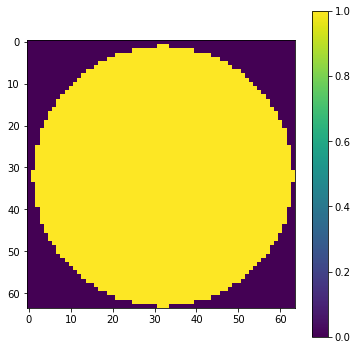

In [331]:
alpha = 1e-9
#alpha = 1e-6

#radius = 0.048 # for nx=32
radius = 0.074
#radius = 1.6 # for nx=64
#radius = 3.2 # for nx=128)
mask = create_3d_mask(x_grid, (0,0,0),radius)
mip_z(jnp.fft.fftshift(mask)); plt.colorbar()
M = 1/jnp.max(sigma_noise)**2 * jnp.ones([nx, nx, nx])
dt_list = jnp.array([0.1, 0.5, 1, 5, 10])
L = 5

pixel_size_nx = pixel_size[0] * 320/nx
B = pixel_size_nx*nx/15
B_list = jnp.array([B, B/2, B/4, B/8])

slice_func, _, _ = get_slice_funcs(project, x_grid, mask, "tri")

loss_func, _, loss_func_sum = get_loss_funcs(slice_func, alpha = alpha)
_, loss_func_batched0, _ = get_loss_funcs(slice_func, alpha = 0)

grad_loss_volume, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

loss_proj_func_batched0 = get_loss_proj_funcs(apply_shifts_and_ctf, x_grid, alpha = 0)

proposal_func_orientations, proposal_func_shifts, proposal_func_vol = get_jax_proposal_funcs(
    loss_func_batched0, loss_proj_func_batched0, loss_func_sum, grad_loss_volume_sum, 
    ctf_params_batch[:4], imgs_batch[:4], sigma_noise, B_list, dt_list, L, M) 

#logPi = lambda v : -loss_func_sum(v, angles_rec, shifts_rec, ctf_params, imgs_f, sigma_noise)
#gradLogPi = lambda v : -jnp.conj(grad_loss_volume_sum(v, angles_rec, shifts_rec, ctf_params, imgs_f, sigma_noise))
#gradLogPi = lambda v : gradLogPi_split(v, angles_rec, shifts, ctf_params, imgs_f, sigma_noise, 10)


In [258]:
N_mc_samples = 8
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

#v0 = (jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx)) )
v0 = jnp.zeros([nx,nx,nx])*1j
#v0 = v_rec

params_vol = {'angles':jnp.array(angles_batch[:4]), 'shifts':jnp.array(shifts_batch[:4])}

t0 = time.time()
v_hmc_mean, r_hmc, v_hmc_samples = mcmc(key, proposal_func_vol, v0, N_mc_samples, params_vol, save_samples=-1)
print(time.time()-t0)


43.32904505729675


1.0


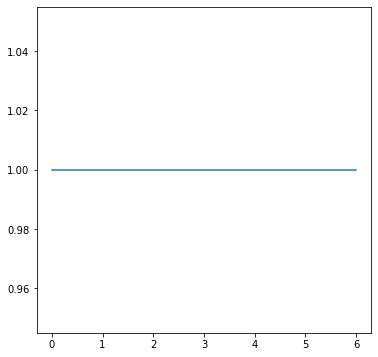

In [259]:
print(jnp.mean(r_hmc))
plt.plot(r_hmc)

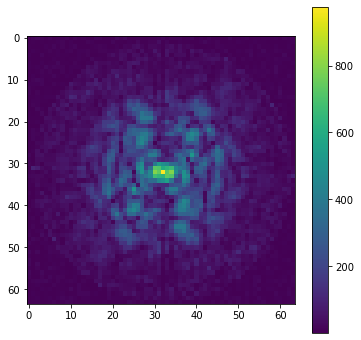

In [260]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_hmc_samples[0,:,:,0]))); plt.colorbar()

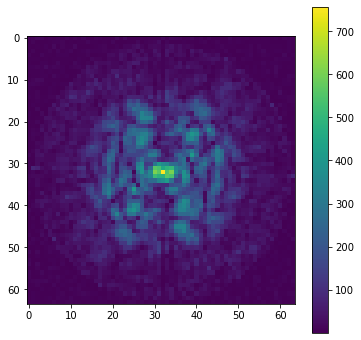

In [261]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_hmc_mean[:,:,0]))); plt.colorbar()

In [262]:
#plt.imshow(jnp.abs(jnp.fft.fftshift(v_rec[:,:,0]))); plt.colorbar()

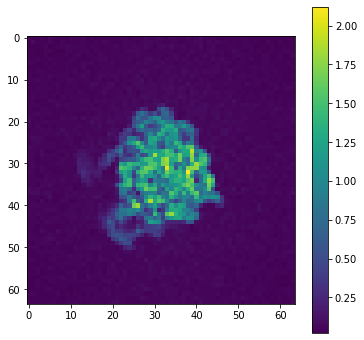

In [263]:
v_hmc_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_hmc_mean)))
mip_z(v_hmc_r)
plt.colorbar()

In [264]:
with mrcfile.new('../data/cryodrgn/v_hmc_mean_alpha1e-9_correct_ang_sh.mrc', overwrite=True) as mrc:
    mrc.set_data(v_hmc_r.astype(np.float32))

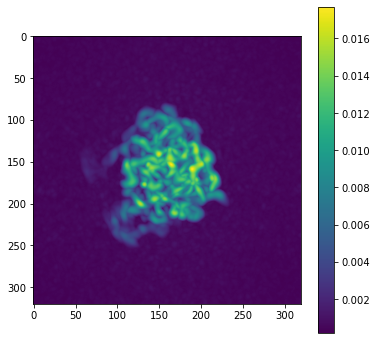

In [265]:
v_hmc_mean_l, x_grid_l = rescale_larger_grid(v_hmc_mean, x_grid, 320)
v_hmc_rl = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_hmc_mean_l)))
mip_z(v_hmc_rl)
plt.colorbar()

In [266]:
with mrcfile.new('../data/cryodrgn/v_hmc_mean_alpha1e-9_320_correct_ang_sh3.mrc', overwrite=True) as mrc:
    mrc.set_data(v_hmc_rl.astype(np.float32))
    


In [ ]:
file = open('../data/cryodrgn/angles_rec', 'wb')
pickle.dump(angles_rec, file)
file.close()

file3 = open('../data/cryodrgn/shifts_rec','wb')
pickle.dump(shifts_rec, file3)
file3.close()

In [ ]:
with open('../data/cryodrgn5000/angles_rec', 'rb') as file:
    # Call load method to deserialze
    angles_rec2 = pickle.load(file)
    
with open('../data/cryodrgn5000/shifts_rec', 'rb') as file:
    # Call load method to deserialze
    shifts_rec2 = pickle.load(file)
    
with open('../data/cryodrgn5000/angles_rec_img_idx', 'rb') as file:
    # Call load method to deserialze
    idxrand2 = pickle.load(file)    
    

In [ ]:
jnp.sum(jnp.abs(angles_rec2 - angles_rec))
jnp.sum(jnp.abs(shifts_rec2 - shifts_rec))
jnp.sum(jnp.abs(idxrand2 - idxrand))

### MCMC shifts

In [332]:
@jax.jit
def rotate_and_interpolate_iter(v, angles):
    return jax.vmap(rotate_and_interpolate, in_axes=(None,0,None,None))(v*mask, angles, x_grid, x_grid)


In [333]:
# OOM if all at once for many images
#t0 = time.time()
#proj = rotate_and_interpolate_iter(v_hmc_mean, angles)
#print(time.time() - t0)

In [334]:
t0 = time.time()
proj_batch = jnp.array([rotate_and_interpolate_iter(v_hmc_mean, angles_batch[i]) for i in jnp.arange(angles_batch.shape[0])])
#proj = jnp.concatenate(proj, axis=0)
print(time.time() - t0)
proj_batch.shape

2.2166056632995605


(8, 5000, 4096)

In [335]:
shifts.shape

(40000, 2)

In [336]:
shifts_batch.shape

(8, 5000, 2)

In [337]:
shifts0.shape

(8, 5000, 2)

In [338]:
jnp.array(shifts_batch.shape[:2]) 

DeviceArray([   8, 5000], dtype=int64)

In [347]:
len(N_batch_shape)

2

In [411]:
angles_batch.shape[:2]

(2, 625)

In [413]:
imgs_batch.shape[:2]

(2, 625)

In [381]:
N_samples_shifts = 201

shifts0 = jnp.array(np.random.randn(4, shifts_batch.shape[1],2))
params_shifts = {'v':v_hmc_mean, 'proj':proj_batch[:4]}
N_batch_shape = jnp.array([4,5000])

t0 = time.time()
_, r_samples_shifts, samples_shifts = mcmc(key, proposal_func_shifts, shifts0, N_samples_shifts, params_shifts, N_batch_shape, 1, verbose = True)
shifts_rec_mc = samples_shifts[N_samples_shifts-2]
print(time.time()-t0)

  MC sample 20 , loss = 2072.7397833094983
  MC sample 40 , loss = 2064.8078479478477
  MC sample 60 , loss = 2060.7913535645716
  MC sample 80 , loss = 2057.2379952884658
  MC sample 100 , loss = 2055.434044625716
  MC sample 120 , loss = 2053.5971873758645
  MC sample 140 , loss = 2052.110568563831
  MC sample 160 , loss = 2050.9224806911557
  MC sample 180 , loss = 2049.9005373693694
  MC sample 200 , loss = 2049.179091509484
73.20173001289368


In [389]:
r_samples_shifts = r_samples_shifts.reshape(N_samples_shifts-1, -1)
samples_shifts = samples_shifts.reshape(N_samples_shifts-1, -1, 2)

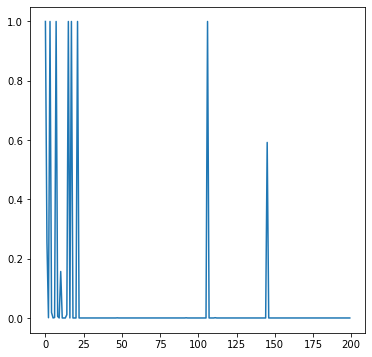

In [383]:
plt.plot(r_samples_shifts[:,0])

In [392]:
shifts_rec_mc = samples_shifts[0]
shifts_rec_mc.shape

(20000, 2)

In [393]:
shifts_batch.shape

(40000, 2)

In [396]:
shifts0.shape

(4, 5000, 2)

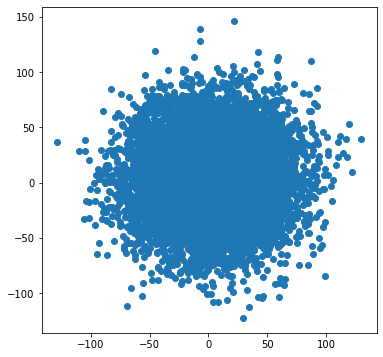

In [397]:
err = shifts_rec_mc - shifts[:20000]
err0 = shifts0.reshape(20000,2) - shifts[:20000]

plt.scatter(err[:,0], err[:,1])

In [398]:
print(jnp.max(shifts))
print(jnp.mean(jnp.abs(err)))
print(jnp.mean(jnp.abs(err0)))

88.15288
20.631555249980256
14.30256268293612


In [ ]:
shifts_rec_mc

In [ ]:
jnp.min(shifts)

### CG - choosing $\alpha$

In [ ]:
centre = (0,0,0)
#radius = 0.045
radius = 0.093
mask = create_3d_mask(x_grid, centre, radius)
mask2d = mask[:,:,0]

plt.imshow(jnp.fft.fftshift(mask2d)); plt.colorbar()

First, the slice function and the data fidelity function (i.e. the loss function with $\alpha=0$):

In [ ]:
slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
fid_func, fid_func_batched, fid_func_sum, _ = get_loss_funcs(slice_func, alpha = 0)

The noise

In [ ]:
print("sigma noise min =", jnp.min(sigma_noise))
print("sigma noise max =", jnp.max(sigma_noise))
print("sigma noise mean =", jnp.mean(sigma_noise))

#sigma_noise = jnp.max(sigma_noise)*jnp.ones(sigma_noise.shape)
plt.imshow(jnp.fft.fftshift(sigma_noise.reshape([nx,nx]))); plt.colorbar()

In [ ]:
imgs_f_m = imgs_f * mask2d.reshape(-1)

In [ ]:
N_iter = 50100
eps = 1e-4
#eps = 1e-5
#eps = 1e-3
#eps = 1e-6
v0 = jnp.zeros([nx,nx,nx])* 1j
#alphas = [1.1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
#alphas = [1e-10, 1e-9, 1e-8]
alphas = [1e-8]
vcgs = []
fids = []
regs = []
losss = []
angles_cg = angles

In [ ]:
N_alpha = len(alphas)
for alpha in alphas[:N_alpha]:
    t0 = time.time()
    print('alpha =', alpha)
    
    loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
    grad_loss_volume, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)
    
    AA, Ab = get_cg_vol_ops(grad_loss_volume_sum, angles_cg, shifts, ctf_params, imgs_f_m, v0.shape, sigma_noise)
    vcg, _ = conjugate_gradient(AA, Ab, v0, N_iter, eps, verbose = True)
    
    fid = 2*fid_func_sum(vcg, angles_cg, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    reg = l2sq(vcg)/(nx*nx*nx)
    loss = loss_func_sum(vcg, angles_cg, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    
    vcgs.append(vcg)
    fids.append(fid)
    regs.append(reg)
    losss.append(loss)
    
    print("  fid =", fid)
    print("  reg =", reg)
    print("  loss =", loss)
    
    print("  Time =", time.time() - t0)
    
vcgs = jnp.array(vcgs)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

In [ ]:
plt.semilogx(alphas, fids)
plt.semilogx(alphas, regs)
plt.semilogx(alphas, losss)
plt.legend(['fid', 'reg', 'fid+reg'])

In [ ]:
plt.plot(fids)

In [ ]:
plt.semilogy(regs)

Pixel-wise loss for the best reconstruction:

In [ ]:
mask.shape

In [ ]:
def pixel_wise_fid_fun(v, slice_func_array, angles, shifts, ctf_params, imgs, sigma):
    err = slice_func_array(v, angles, shifts, ctf_params) - imgs
    return jnp.mean(jnp.real(jnp.conj(err)*err), axis = 0)/(2*sigma**2)
    #return jnp.mean(jnp.real(jnp.conj(err)*err), axis = 0)/2

In [ ]:
alphas[alpha_idx]

In [ ]:
sigma_noise1 = jnp.ones(sigma_noise.shape)

In [ ]:
pw_fid = pixel_wise_fid_fun(vcgs[0], slice_func_array, angles, shifts, ctf_params, imgs_f_m, sigma_noise1)
plt.imshow(jnp.fft.fftshift(pw_fid.reshape([nx,nx]))); plt.colorbar()

Pixel-wise loss for the ZERO volume:

In [ ]:
pw_fid0 = pixel_wise_fid_fun(jnp.zeros(v0.shape), slice_func_array, angles_rec, shifts, ctf_params, imgs_f_m, sigma_noise1)
plt.imshow(jnp.fft.fftshift(pw_fid0.reshape([nx,nx]))); plt.colorbar()

In [ ]:
alpha_idx = jnp.argmin(fids)
print(alpha_idx)

In [ ]:
#alpha_idx = 2

In [ ]:
print(alphas[alpha_idx])
plt.imshow(jnp.abs(jnp.fft.fftshift(vcgs[alpha_idx][:,0,:]))); plt.colorbar()

In [ ]:
img_idx = 100
s0 = slice_func(vcgs[alpha_idx], angles_cg[img_idx], shifts[img_idx], ctf_params[img_idx])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

In [ ]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[img_idx]).reshape(nx,nx))); plt.colorbar()

In [ ]:
plt.imshow(jnp.fft.fftshift(jnp.abs(s0 - imgs_f[img_idx]).reshape(nx,nx))); plt.colorbar()

In [ ]:
vr_rec = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))
mip_z(vr_rec)
plt.colorbar()
plt.title('Reconstruction MIP')

In [ ]:
vcg_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcgs[alpha_idx])))
mip_z(vcg_r)
plt.colorbar()
plt.title('Reconstruction MIP')


In [ ]:
with mrcfile.new('../data/reconstruction_data_32_cg_alpha.mrc', overwrite=True) as mrc:
    mrc.set_data(vcg_r.astype(np.float32))

### All images are the same, with different scalings (corresponding to different orders of $\alpha$)

In [ ]:
vcgs_s = vcgs[:,:,0,0]
vcgs_s.shape

In [ ]:
plt.plot(jnp.abs(vcgs_s[0]))
plt.plot(jnp.abs(vcgs_s[1])*9)
plt.plot(jnp.abs(vcgs_s[2])*90)
plt.plot(jnp.abs(vcgs_s[3])*900)
plt.plot(jnp.abs(vcgs_s[6])*9e5)
plt.plot(jnp.abs(vcgs_s[8])*9e7)
plt.plot(jnp.abs(vcgs_s[10])*9e8)

### FSC, orientations, standard deviation for each voxel etc

In [ ]:
vcg1 = vcgs[0]
vcg2 = vcgs[6]

In [ ]:
res, fsc, shell_points = calc_fsc(vcg1, vcg2, x_grid)

In [ ]:
points_v_tri = points_orientations_tri(angles, x_grid[1].astype(jnp.int64), number_of_batches = 1000)
#points_v_nn = points_orientations_nn(angles[:1000], x_grid[1])

In [ ]:
plt.imshow(jnp.fft.fftshift(points_v_tri[:,:,0])); plt.colorbar()

In [ ]:
res_spu, spu_tri = shell_points_used(points_v_tri, x_grid)

In [ ]:
plt.plot(res, fsc)
plt.plot(res_spu, spu_tri)
plt.hlines([0.143, 0.5], xmin=min(res), xmax=max(res), colors = ['gray'], linestyles=['dashed'])
plt.legend(['FSC', 'fraction shell points used', '0.143, 0.5'])
#plt.title('Clustered angles')

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[0,:,:]*mask[0,:,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,0,:]*mask[:,0,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,:,0]*mask[:,:,0]))))); plt.colorbar()

In [ ]:
vones = jnp.ones(vcg1.shape)
omega = AA(vones)
omega = 1/omega

In [ ]:
jnp.min(jnp.abs(omega))

In [ ]:
plt.title("Standard deviation")
plt.imshow(jnp.abs(jnp.fft.fftshift(omega[0,:,:]))); plt.colorbar()

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(omega[:,0,:]))); plt.colorbar()

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(omega[:,:,0]))); plt.colorbar()

### SGD

### Preconditioner

In [ ]:
P = get_preconditioner(x_grid) * mask
#P = jnp.sqrt(P) /jnp.max(P) + 1e-6
#P = jnp.sqrt(P)
P = P**0.15
P = P /jnp.max(P)+ 1e-6
plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))
print(jnp.min(P))

### Points/orientations preconditioner

In [ ]:
P = points_v_tri +1
P = 1/P * mask + 1e-12
P = P/jnp.max(P) * mask
plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))
print(jnp.min(P))

### $\alpha$ tuning

In [ ]:
mask2d = mask[:,:,0]
imgs_f_m = imgs_f * mask2d.reshape(-1)

In [ ]:
N_epoch = 501000
batch_size = 300
#learning_rate = 100000
learning_rate = 10000 * 100
#learning_rate = 10000 # for "large" alpha

P = None

#eps = 3e-5
#eps = 1e-3
#eps = 1e-9
eps = 1e-8
v0 = jnp.zeros([nx,nx,nx])* 1j
#alphas = 1/100 * jnp.array([1e-9, 1e-8, 1e-7, 1.1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]) #, 1e0, 1e1, 1e2, 1e3]
#alphas = [1e-10, 1e-9, 1e-8, 1e-7]
alphas = [1e-9]

angles_gd = angles

In [ ]:
vgds = []
fids = []
regs = []
losss = []

#N_alpha = 4
for alpha in alphas:
    t0 = time.time()
    print('alpha =', alpha)
    
    slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
    loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)

    grad_loss_volume, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

    sgd_grad_func = get_sgd_vol_ops(grad_loss_volume_sum, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)
    
    vgd = sgd(sgd_grad_func, N, v0, learning_rate, N_epoch, batch_size, P, eps, verbose = True)
    
    fid = 2*fid_func_sum(vgd, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    reg = l2sq(vgd)/(nx*nx*nx)
    loss = loss_func_sum(vgd, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    
    vgds.append(vgd)
    fids.append(fid)
    regs.append(reg)
    losss.append(loss)
    
    print("  fid =", fid)
    print("  reg =", reg)
    print("  loss =", loss)
    
    print("  Time =", time.time() - t0)
    
vgds = jnp.array(vgds)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

In [ ]:
vgds = jnp.array(vgds)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

N_alpha= len(fids)

In [ ]:
plt.semilogx(alphas[:N_alpha], fids)
plt.semilogx(alphas[:N_alpha], regs)
plt.semilogx(alphas[:N_alpha], losss)
plt.legend(['fid', 'reg', 'fid+reg'])

In [ ]:
plt.plot(fids)

In [ ]:
plt.semilogy(regs)

In [ ]:
alphas[2]

In [ ]:
#alpha_idx= 3
#alpha_idx=5
#alpha_idx=0

In [ ]:
pw_fid = pixel_wise_fid_fun(vgds[alpha_idx], slice_func_array, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid.reshape([nx,nx]))); plt.colorbar()
print(jnp.max(pw_fid))

In [ ]:
pw_fid0 = pixel_wise_fid_fun(jnp.zeros(vgd.shape), slice_func_array, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid0.reshape([nx,nx]))); plt.colorbar()
print(jnp.max(pw_fid))

In [ ]:
plt.imshow(jnp.fft.fftshift(jnp.abs(vgds[alpha_idx,:,0,:]))); plt.colorbar()

In [ ]:
#plt.imshow(jnp.fft.fftshift(jnp.abs(v_rec[:,0,:]))); plt.colorbar()

In [ ]:
#err = vgds[1] - v_rec
#plt.imshow(jnp.fft.fftshift((jnp.abs(err[:,0,:]))*mask[:,0,:])); plt.colorbar()

In [ ]:
vgds_s = vgds[:,:,0,0]
vgds_s.shape

plt.plot(jnp.abs(vgds_s[0]))
plt.plot(jnp.abs(vgds_s[1])*1.1)
plt.plot(jnp.abs(vgds_s[2])*2)
plt.plot(jnp.abs(vgds_s[3])*7)


In [ ]:
vr_sgd = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vgds[alpha_idx])))
mip_z(vr_sgd)
plt.colorbar()
plt.title('Reconstruction MIP')

In [ ]:
vr_rec = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))
mip_z(vr_rec)
plt.colorbar()
plt.title('Reconstruction MIP')

In [ ]:
with mrcfile.new('../data/reconstruction_data_32_sgd_alpha.mrc', overwrite=True) as mrc:
    mrc.set_data(vr_sgd.astype(np.float32))

In [ ]:
idx = 100

In [ ]:
slicegd = slice_func(vgds[alpha_idx], angles_gd[idx], shifts[idx], ctf_params[idx])
#slicerec = slice_func(v_rec, angles_gd[idx], shifts[idx], ctf_params[idx])

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(slicegd.reshape([nx,nx])))); plt.colorbar()

In [ ]:
#plt.imshow(jnp.abs(jnp.fft.fftshift(slicerec.reshape([32,32])))); plt.colorbar()

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(imgs_f[idx].reshape([nx,nx])))); plt.colorbar()

### C3 Symmetry

In [ ]:
def split(arr):
    N = arr.shape[0]
    N2 = jnp.floor(N/2).astype(jnp.int32)

    arr_train = arr[:N2]
    arr_test  = arr[N2:]
    
    return arr_train, arr_test

def split_and_triple(arr):
    N = arr.shape[0]
    N2 = jnp.floor(N/2).astype(jnp.int32)

    arr_train = jnp.tile(arr[:N2], reps=(3,1))
    arr_test  = jnp.tile(arr[N2:], reps=(3,1))
    
    return arr_train, arr_test

def split_and_triple_angles(a):
    N = a.shape[0]
    N2 = jnp.floor(N/2).astype(jnp.int32)

    a_train1 = a[:N2]
    a_train2 = a_train1.copy()
    a_train3 = a_train1.copy()

    a_train2[:,2] += 2*jnp.pi/3
    a_train3[:,2] += 4*jnp.pi/3
   
    a_train = jnp.concatenate([a_train1, a_train2, a_train3], axis=0)
    
    a_test1  = a[N2:]
    a_test2 = a_test1.copy()
    a_test3 = a_test1.copy()

    a_test2[:,2] += 2*jnp.pi/3
    a_test3[:,2] += 4*jnp.pi/3
    
    a_test = jnp.concatenate([a_test1, a_test2, a_test3], axis=0)


    return a_train, a_test

In [ ]:
imgs_train, imgs_test = split_and_triple(imgs_f)
shifts_train, shifts_test = split_and_triple(shifts)
ctf_params_train, ctf_params_test = split_and_triple(ctf_params)
angles_train, angles_test = split_and_triple_angles(angles)
N = imgs_train.shape[0]

#plot_angles(angles[:1000])

In [ ]:
#imgs_train, imgs_test = split(imgs_f)
#shifts_train, shifts_test = split(shifts)
#ctf_params_train, ctf_params_test = split(ctf_params)
#angles_train, angles_test = split(angles)
#N = imgs_train.shape[0]
#plot_angles(angles_train)

### Volume residual

In [ ]:
plt.plot(angles[:,1])

In [ ]:
p1 = np.random.randn(N) * 0 #np.pi/20
p2 = np.random.randn(N) * 0 #np.pi/40 + np.pi/2
p3 = np.random.randn(N) * np.pi/10

angles_train_pert = angles_train + jnp.array([p1,p2,p3]).transpose()

In [ ]:
N

In [ ]:
idx = 102
aa = jnp.array([angles_train[idx], angles_train_pert[idx]])
plot_angles(aa)

In [ ]:
#angles_rec = angles_train
angles_rec = angles_train_pert

In [ ]:
alpha = 1e-9
N_train = jnp.floor(N/2).astype(jnp.int32) #3000

radius = 0.0925
mask = create_3d_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()
M = 1/jnp.max(sigma_noise)**2 * jnp.ones([nx, nx, nx])

slice_func, slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

logPi = lambda v : -loss_func_sum(v, angles_rec, shifts_train, ctf_params_train, imgs_train, sigma_noise)
gradLogPi = lambda v : -jnp.conj(grad_loss_volume_sum(v, angles_rec, shifts_train, ctf_params_train, imgs_train, sigma_noise))


In [ ]:
N_mc_samples = 101
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

v0 = jnp.zeros([nx,nx,nx])*1j
dt_list = jnp.array([0.01, 0.1, 0.5, 5, 10])
proposal_params_hmc = {"dt_list" : dt_list, "L" : 10, "M" : M, "gradLogPi" : gradLogPi}

t0 = time.time()
v_rec_pert, r_hmc, v_hmc_samples = mcmc(key, N_mc_samples, proposal_hmc, logPi, v0, proposal_params_hmc)
print(time.time()-t0)

In [ ]:
N

In [ ]:
print(jnp.mean(r_hmc))
plt.plot(r_hmc)

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_rec_pert[:,:,0]))); plt.colorbar()

In [ ]:
v_rec_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_pert)))
mip_z(v_rec_r)
plt.colorbar()

In [ ]:
with mrcfile.new('../data/3dfsc/v_rec_vol_hmc_64_triple_pert.mrc', overwrite=True) as mrc:
    mrc.set_data(v_rec_r.astype(np.float32))

In [ ]:
plt.imshow(jnp.fft.fftshift(sigma_noise.reshape([64,64])))

In [ ]:
N_batches = 60000 
#v_resid = get_volume_residual(v_rec, angles[N_train:N_train+2000], shifts[N_train:N_train+2000], ctf_params[N_train:N_train+2000], imgs_f[N_train:N_train+2000], sigma_noise, x_grid, slice_func_array, N_batches)
v_resid_pert = get_volume_residual(v_rec_pert, angles_test, shifts_test, ctf_params_test, imgs_test, sigma_noise, x_grid, slice_func_array, N_batches)
                          

In [ ]:
plt.imshow(jnp.fft.fftshift(v_resid_pert[:,:,0]*mask[:,:,0])); plt.colorbar()

In [ ]:
v_resid_print = jnp.fft.fftshift(v_resid_pert*mask)
with mrcfile.new('../data/3dfsc/v_resid_64_pert.mrc', overwrite=True) as mrc:
    mrc.set_data(v_resid_print.astype(np.float32))

In [ ]:
v_resid_zero = get_volume_residual(jnp.zeros(v_rec.shape), angles_test, shifts_test, ctf_params_test, imgs_test, sigma_noise, x_grid, slice_func_array, N_batches)


In [ ]:
plt.imshow(jnp.fft.fftshift(v_resid_zero[:,:,0]*mask[:,:,0])); plt.colorbar()

In [ ]:
v_resid_zero_print = jnp.fft.fftshift(v_resid_zero*mask)
with mrcfile.new('../data/3dfsc/v_resid_64_zero.mrc', overwrite=True) as mrc:
    mrc.set_data(v_resid_zero_print.astype(np.float32))

In [ ]:
v_resid_m = jnp.fft.fftshift(v_resid*mask)
v_resid_pert_m = jnp.fft.fftshift(v_resid_pert*mask)
v_resid_zero_m = jnp.fft.fftshift(v_resid_zero*mask)

In [ ]:
jnp.max(v_resid_m)

In [ ]:
jnp.max(v_resid_zero_m)

In [ ]:
print(jnp.max(v_resid_m))
print(jnp.max(v_resid_pert_m))
print(jnp.max(v_resid_zero_m))
plot_vmax = jnp.max(jnp.array([v_resid_m, v_resid_pert_m, v_resid_zero_m]))
#plot_vmax = jnp.max(jnp.array([v_resid_m, v_resid_zero_m]))

print(plot_vmax)

In [ ]:
plt.imshow(v_resid_m[:,:,32], vmin=0, vmax=plot_vmax)
plt.colorbar()
#plt.title('True angles')

#plt.savefig('v_resid_slice.png')

In [ ]:
plt.imshow(v_resid_pert_m[:,:,32], vmin=0, vmax=plot_vmax)
plt.colorbar()
#plt.title('Perturbed angles')
#plt.savefig('v_resid_pert_slice.png')

In [ ]:
plt.imshow(v_resid_zero_m[:,:,32], vmin=0, vmax=plot_vmax)
plt.colorbar()
#plt.title('Perturbed angles')
#plt.savefig('v_resid_zero_slice.png')

### Plots

### Separate the projection step

In [ ]:
# Force garbage collection when it throws OOM on GPU for small amount.
#import gc
#gc.collect()

In [ ]:
from src.residual import *
N_batches = 60000

resid = get_3d_residuals_list(v_rec, angles_rec[N_train:5000], shifts[N_train:], ctf_params[N_train:], imgs_f[N_train:], slice_func_array)
coords = get_3d_coords_list(angles_rec[N_train:5000], x_grid)

v_resid2 = get_volume_residual(coords, resid, x_grid, N_batches)



In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_resid2[:,:,0]*mask[:,:,0]))); plt.colorbar()

In [ ]:
jnp.sum(jnp.abs(v_resid-v_resid2))

In [ ]:
resid.shape

In [ ]:
coords.shape

In [ ]:
resid = get_3d_residuals_list(v_rec, angles_rec[N_train:5000], shifts[N_train:], ctf_params[N_train:], imgs_f[N_train:], slice_func_array)
coords = get_3d_coords_list(angles_rec[N_train:5000], x_grid)

v_resid2 = get_volume_residual(coords, resid, x_grid, N_batches)




In [ ]:
from src.residual import *

In [ ]:
N_batches = 60000
v_resid2 = get_v_resid_from_v_batch(v_rec, angles_rec[N_train:N_train+2], shifts[N_train:N_train+2], ctf_params[N_train:N_train+2], imgs_f[N_train:N_train+2], slice_func_array, x_grid, N_batches)


In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_resid2[:,:,0]*mask[:,:,0]))); plt.colorbar()




In [ ]:
slice_func_array_jit = jax.jit(slice_func_array)

In [ ]:
jnp.sum(jnp.abs(v_resid-v_resid2))